In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import treebank
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, SimpleRNN, LSTM, GRU, Activation, Dropout

In [2]:
sentences = treebank.tagged_sents(tagset='universal')

examples = []
labels = []
vocab = set([])
pos = set([])
maxLength = 0
argmaxLength = 0

for sentence in sentences:
    
    if maxLength<len(sentence):
        maxLength = len(sentence)
        argmaxLength = sentence
    example = []
    label = []
    for unit in sentence:
        word = unit[0].lower()
        example.append(word)
        label.append(unit[1])
        vocab.add(word)
        pos.add(unit[1])
    examples.append(example)
    labels.append(label)

In [3]:
input_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
input_tokenizer.fit_on_texts(examples)
input_tensor = input_tokenizer.texts_to_sequences(examples)
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor,padding='post')

pos_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
pos_tokenizer.fit_on_texts(labels)
pos_tensor = pos_tokenizer.texts_to_sequences(labels)
pos_tensor = tf.keras.preprocessing.sequence.pad_sequences(pos_tensor,padding='post')

input_train,input_val,output_train, output_val = train_test_split(input_tensor,
                                                                  pos_tensor,test_size=0.2, 
                                                                  random_state=123)

In [8]:
BATCH_SIZE = 128
embedding_dim = 50

BUFFER_SIZE = len(input_train)
steps_per_epoch = len(input_train)//BATCH_SIZE
vocab_inp_size = len(vocab)+1
vocab_tar_size = len(pos)+1
val_steps = len(input_val)//BATCH_SIZE

train_dataset = tf.data.Dataset.from_tensor_slices((input_train, output_train)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((input_val, output_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
# SIMPLE RNN
# model = Sequential([Embedding(vocab_inp_size, embedding_dim,input_length = input_train.shape[1], name="embedding"),
#                     SimpleRNN(64,return_sequences=True),
#                     Dense(vocab_tar_size, activation='softmax')])


# GRU
# model = Sequential([Embedding(vocab_inp_size, embedding_dim,input_length = input_train.shape[1], name="embedding"),
#                     GRU(64, return_sequences=True),
#                     Dense(vocab_tar_size, activation='softmax')])

# BIDIRECTIONAL GRU
model = Sequential([Embedding(vocab_inp_size, embedding_dim,input_length = input_train.shape[1], name="embedding"),
                    Bidirectional(GRU(64, return_sequences=True)),
                    Dense(vocab_tar_size, activation='softmax')])


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 271, 50)           569400    
_________________________________________________________________
bidirectional (Bidirectional (None, 271, 128)          44544     
_________________________________________________________________
dense_4 (Dense)              (None, 271, 13)           1677      
Total params: 615,621
Trainable params: 615,621
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(train_dataset,epochs=10,validation_data=val_dataset,validation_steps=val_steps)

Epoch 1/10
24/24 [==============================] - 14s 569ms/step - loss: 1.6473 - accuracy: 0.8681 - val_loss: 0.3169 - val_accuracy: 0.9064
Epoch 2/10
24/24 [==============================] - 13s 557ms/step - loss: 0.2975 - accuracy: 0.9087 - val_loss: 0.2414 - val_accuracy: 0.9260
Epoch 3/10
24/24 [==============================] - 15s 639ms/step - loss: 0.2402 - accuracy: 0.9308 - val_loss: 0.2341 - val_accuracy: 0.9323
Epoch 4/10
24/24 [==============================] - 15s 639ms/step - loss: 0.2337 - accuracy: 0.9311 - val_loss: 0.2273 - val_accuracy: 0.9313
Epoch 5/10
24/24 [==============================] - 17s 698ms/step - loss: 0.2250 - accuracy: 0.9313 - val_loss: 0.2168 - val_accuracy: 0.9324
Epoch 6/10
24/24 [==============================] - 22s 924ms/step - loss: 0.2123 - accuracy: 0.9319 - val_loss: 0.2046 - val_accuracy: 0.9330
Epoch 7/10
24/24 [==============================] - 19s 811ms/step - loss: 0.2010 - accuracy: 0.9336 - val_loss: 0.1951 - val_accuracy: 0.9360

In [ ]:
loss, accuracy = model.evaluate(val_dataset, verbose = 1)
print(“Loss: {0},\nAccuracy: {1}”.format(loss, accuracy))

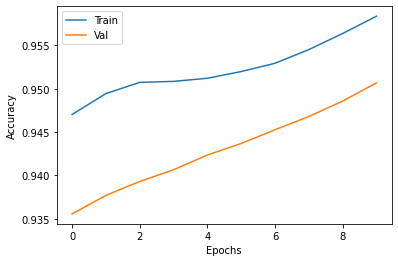

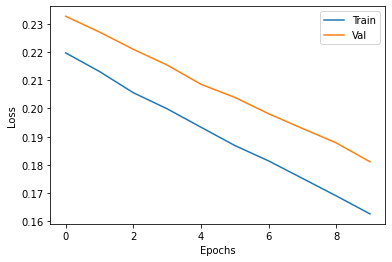

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'])
plt.show()